In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import stats
import os, json
import seaborn as sns

def load_and_process_data(benchmark_path: str, results_path: str):
    with open(benchmark_path) as f:
        benchmark = json.load(f)
    with open(results_path) as f:
        results = json.load(f)
        
    df_benchmark = pd.DataFrame.from_dict(benchmark, orient='index')
    
    processed_results = {}
    for pdb_id, data in results.items():
        try:
            processed_results[pdb_id] = {
                'ba_val': data['ba_val'],
                #'kd': data['kd'],
                'CC': data['contacts']['CC'],
                'CP': data['contacts']['CP'],
                'AC': data['contacts']['AC'],
                'PP': data['contacts']['PP'],
                'AP': data['contacts']['AP'],
                'AA': data['contacts']['AA'],
                'nis_p': data['nis']['polar'],
                'nis_a': data['nis']['aliphatic'],
                'nis_c': data['nis']['charged'],
                'execution_time': data['execution_time']["seconds"]
            }
        except KeyError as e:
            print(f"Warning: Missing data for {pdb_id}: {e}")
            continue
            
    df_results = pd.DataFrame.from_dict(processed_results, orient='index')
    
    return df_benchmark, df_results

def calculate_correlations(df_benchmark: pd.DataFrame, df_results: pd.DataFrame):
    common_pdbs = sorted(set(df_benchmark.index) & set(df_results.index))
    print(f"Common PDB entries: {len(common_pdbs)}")
    
    metrics = {
        'ba_val': 'Binding Affinity',
        'CC': 'Charged-Charged contacts',
        'CP': 'Charged-Polar contacts',
        'AC': 'Aliphatic-Charged contacts',
        'PP': 'Polar-Polar contacts',
        'AP': 'Aliphatic-Polar contacts',
        'AA': 'Aliphatic-Aliphatic contacts',
        'nis_p': 'NIS Polar',
        'nis_a': 'NIS Aliphatic',
        'nis_c': 'NIS Charged'
    }
    
    correlations = []
    for metric in metrics:
        if metric in df_benchmark.columns and metric in df_results.columns:
            bench_vals = df_benchmark.loc[common_pdbs, metric]
            result_vals = df_results.loc[common_pdbs, metric]
            pearson = stats.pearsonr(bench_vals, result_vals)
            rmse = np.sqrt(np.mean((bench_vals - result_vals) ** 2))
            correlations.append({
                'Metric': metrics[metric],
                'Pearson r': pearson[0],
                'p-value': pearson[1],
                'RMSE': rmse
            })
    
    return pd.DataFrame(correlations)

def plot_correlations(df_benchmark: pd.DataFrame, df_results: pd.DataFrame, output_dir: str):
    os.makedirs(output_dir, exist_ok=True)
    common_pdbs = sorted(set(df_benchmark.index) & set(df_results.index))
    
    metrics = {
        'ba_val': 'Binding Affinity',
        'CC': 'Charged-Charged contacts',
        'CP': 'Charged-Polar contacts',
        'AC': 'Aliphatic-Charged contacts',
        'PP': 'Polar-Polar contacts',
        'AP': 'Aliphatic-Polar contacts',
        'AA': 'Aliphatic-Aliphatic contacts',
        'nis_p': 'NIS Polar',
        'nis_a': 'NIS Aliphatic',
        'nis_c': 'NIS Charged'
    }
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, (metric, title) in enumerate(metrics.items()):
        if i < len(axes):
            bench_vals = df_benchmark.loc[common_pdbs, metric]
            result_vals = df_results.loc[common_pdbs, metric]
            
            pearson = stats.pearsonr(bench_vals, result_vals)[0]
            
            ax = axes[i]
            ax.scatter(bench_vals, result_vals, alpha=0.6)
            ax.plot([min(bench_vals), max(bench_vals)], 
                   [min(bench_vals), max(bench_vals)], 'r--')
            
            ax.set_xlabel('Prodigy ORG')
            ax.set_ylabel('Prodigy JAX')
            ax.set_title(f'{title}\nr = {pearson:.3f}')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/correlations.png', dpi=300, bbox_inches='tight')
    plt.show()

def add_sequence_lengths(df: pd.DataFrame, pdb_folder: str):
    lengths = {}
    for pdb_id in df.index:
        try:
            pdb_file = os.path.join(pdb_folder, f"{pdb_id}.pdb")
            if os.path.exists(pdb_file):
                with open(pdb_file, 'r') as f:
                    lines = f.readlines()
                    # Count ATOM lines for chain A and B
                    chain_a = sum(1 for line in lines if line.startswith('ATOM') and line[21] == 'A')
                    chain_b = sum(1 for line in lines if line.startswith('ATOM') and line[21] == 'B')
                    # Divide by typical number of atoms per residue (usually around 8-10)
                    lengths[pdb_id] = {
                        'chain_a_length': chain_a // 8,
                        'chain_b_length': chain_b // 8
                    }
        except Exception as e:
            print(f"Error processing {pdb_id}: {e}")
            
    # Add to DataFrame
    length_df = pd.DataFrame.from_dict(lengths, orient='index')
    return pd.concat([df, length_df], axis=1)

def compare_sasa_results(gpu_dir: str, cpu_dir: str):
    gpu_path = Path(gpu_dir)
    cpu_path = Path(cpu_dir)
    all_comparisons = []
    all_sasa_values = []
    
    for protein_dir in gpu_path.glob("*"):
        print("")
        if not protein_dir.is_dir():
            continue
            
        protein_name = protein_dir.name
        gpu_csv = list(protein_dir.rglob("*.csv"))
        cpu_csv = list((cpu_path / protein_name).rglob("*.csv"))
        
        if not gpu_csv or not cpu_csv:
            continue
        
        gpu_data = pd.read_csv(gpu_csv[0])
        gpu_data.resid = gpu_data.resid.astype(int)
        gpu_data = gpu_data.sort_values(['chain', "resname", 'resid', 'atom'])
        cpu_data = pd.read_csv(cpu_csv[0])
        cpu_data.resid = cpu_data.resid.astype(int)
        cpu_data = cpu_data.sort_values(['chain', "resname", 'resid', 'atom'])

        if len(gpu_data) != len(cpu_data):
            print(f"Length mismatch in {protein_name}: GPU={len(gpu_data)}, CPU={len(cpu_data)}")
            continue
        
        comparison = pd.DataFrame({
          'sasa_cpu': cpu_data['sasa'].values,
          'sasa_gpu': gpu_data['sasa'].values,
          'diff': abs(cpu_data['sasa'].values - gpu_data['sasa'].values),
          'protein': protein_name,
          'chain_gpu': gpu_data['chain'].values,
          'resname_gpu': gpu_data['resname'].values, 
          'resid_gpu': gpu_data['resid'].values,
          'atom_gpu': gpu_data['atom'].values,
          'chain_cpu': cpu_data['chain'].values,
          'resname_cpu': cpu_data['resname'].values,
          'resid_cpu': cpu_data['resid'].values, 
          'atom_cpu': cpu_data['atom'].values
        })
        
        all_sasa_values.append(comparison)
        
        rmse = np.sqrt(np.mean(comparison['diff']**2))
        correlation = stats.pearsonr(comparison['sasa_cpu'], comparison['sasa_gpu'])[0]
        
        all_comparisons.append({
            'protein': protein_name,
            'rmse': rmse,
            'correlation': correlation,
            'mean_diff': comparison['diff'].mean(),
            'max_diff': comparison['diff'].max(),
            'num_atoms': len(comparison),
            'num_nonzero': len(comparison[comparison['sasa_gpu'] > 0])
        })
    
    summary_df = pd.DataFrame(all_comparisons)
    all_sasa_df = pd.concat(all_sasa_values)
    
    # Add high_rmse column to all_sasa_df
    high_rmse_proteins = set(summary_df[summary_df['rmse'] > 2]['protein'])
    all_sasa_df['high_rmse'] = all_sasa_df['protein'].isin(high_rmse_proteins)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # RMSE scatter plot
    ax1.scatter(summary_df['num_atoms'], summary_df['rmse'], alpha=0.6)
    for i, txt in enumerate(summary_df['protein']):
        if summary_df['rmse'].iloc[i] > 2:
            ax1.annotate(txt, (summary_df['num_atoms'].iloc[i], summary_df['rmse'].iloc[i]))
    ax1.set_xlabel('Number of Atoms')
    ax1.set_ylabel('RMSE (Å²)')
    ax1.set_title('RMSE GPU and CPU vs Structure Size')
    
    # SASA values comparison with color coding
    normal_points = all_sasa_df[~all_sasa_df['high_rmse']]
    high_rmse_points = all_sasa_df[all_sasa_df['high_rmse']]
    
    ax2.scatter(normal_points['sasa_cpu'], normal_points['sasa_gpu'], alpha=0.1, color='blue')
    
    max_val = max(all_sasa_df['sasa_cpu'].max(), all_sasa_df['sasa_gpu'].max())
    ax2.plot([0, max_val], [0, max_val], 'k--')
    ax2.set_xlabel('CPU SASA (Å²)')
    ax2.set_ylabel('GPU SASA (Å²)')
    ax2.set_title('CPU vs GPU SASA Values')
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig('sasa_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return summary_df, all_sasa_df

In [ ]:
benchmark = "./benchmark_af/dataset.json"
results = "./benchmark_af/20250126_140901_gpu/combined_results.json"
output = "output_comp"
dataset = "./benchmark_af/PRODIGYdataset/" # make sure you have the dataset
os.makedirs(output, exist_ok=True)
df_benchmark, df_results = load_and_process_data(benchmark, results)
correlations = calculate_correlations(df_benchmark, df_results)
print("\nCorrelation Analysis:")
print(correlations.to_string(index=False))
correlations.to_csv(f'{output}/correlations.csv', index=False)
plot_correlations(df_benchmark, df_results, output)

# Save processed DataFrames
df_benchmark.to_csv(f'{output}/benchmark_processed.csv')
df_results.to_csv(f'{output}/results_processed.csv')

df = add_sequence_lengths(df_results, dataset)
df['total_length'] = df['chain_a_length'] + df['chain_b_length']

plt.figure(figsize=(10, 6))
plt.scatter(df['total_length'], df['execution_time'])

# Add trend line
z = np.polyfit(df['total_length'], df['execution_time'], 1)
p = np.poly1d(z)
plt.plot(df['total_length'], p(df['total_length']), "r--", alpha=0.8)

# Calculate correlation
corr = df['total_length'].corr(df['execution_time'])

plt.xlabel('Total Sequence Length (residues)')
plt.ylabel('Execution Time (s)')
plt.title(f'Execution Time vs Sequence Length\nCorrelation: {corr:.3f}')
plt.grid(True, alpha=0.3)
summary_df, all_sasa_df = compare_sasa_results("./benchmark_af/20250126_140901_gpu", "./benchmark_af/20250127_160612_cpu")


In [8]:
from bio_lib.custom_prodigy_jax import *

def convert_sasa_to_array(
    complex_sasa: jnp.ndarray,
    relative_sasa: jnp.ndarray,
    target: Protein,
    binder: Protein,
) -> np.ndarray:
    atoms_per_res = 37
    atom_types = np.array(residue_constants.atom_types)
    restypes = residue_constants.restypes #+ ['X']
    restype_1to3 = residue_constants.restype_1to3

    # Combine target and binder data
    target_res = len(target.aatype)
    binder_res = len(binder.aatype)
    total_res = target_res + binder_res

    # Combined atom mask (flattened)
    combined_mask = jnp.concatenate([target.atom_mask, binder.atom_mask]).ravel()
    combined_mask_np = np.asarray(combined_mask, dtype=bool)

    # Chain IDs for each residue
    chain_ids = np.concatenate([np.full(target_res, 'A'), np.full(binder_res, 'B')])

    # Residue indices (1-based)
    res_indices = np.concatenate([target.residue_index, binder.residue_index]).astype(int)

    # Residue names using vectorized lookup
    restype_1to3_arr = np.array([restype_1to3[r] for r in restypes], dtype='U3')
    target_resnames = restype_1to3_arr[np.array(target.aatype)]
    binder_resnames = restype_1to3_arr[np.array(binder.aatype)]
    resnames = np.concatenate([target_resnames, binder_resnames])

    # Atom names for all atoms
    atom_names = np.tile(atom_types, total_res)

    # Expand residue-level data to atom-level
    chain_ids_atom = np.repeat(chain_ids, atoms_per_res)
    resnames_atom = np.repeat(resnames, atoms_per_res)
    resindices_atom = np.repeat(res_indices, atoms_per_res)
    relative_sasa_atom = np.repeat(relative_sasa, atoms_per_res)

    # Apply mask to filter valid atoms
    filtered_data = (
        chain_ids_atom[combined_mask_np],
        resnames_atom[combined_mask_np],
        resindices_atom[combined_mask_np],
        atom_names[combined_mask_np],
        np.asarray(complex_sasa)[combined_mask_np],
        relative_sasa_atom[combined_mask_np]
    )

    # Create structured array
    dtype = [
        ('chain', 'U1'), ('resname', 'U3'), ('resindex', 'i4'),
        ('atomname', 'U4'), ('atom_sasa', 'f4'), ('relative_sasa', 'f4')
    ]
    return np.array(list(zip(*filtered_data)), dtype=dtype)

def predict_binding_affinity_jax(
    pdb_path: str | Path,
    selection: str = "A,B",
    cutoff: float = 5.5,
    acc_threshold: float = 0.05,
    temperature: float = 25.0,
    output_dir: Optional[str] = ".",
    quiet: bool = True,
) -> ProdigyResults:
    """Run the full PRODIGY analysis pipeline."""
    target_chain, binder_chain = selection.split(",")
    target, binder = load_pdb_to_af(pdb_path, target_chain, binder_chain)
    complex_positions = jnp.concatenate([target.atom_positions, binder.atom_positions], axis=0).reshape(-1, 3)
    complex_radii = jnp.concatenate([get_atom_radii(target.aatype), get_atom_radii(binder.aatype)])
    complex_mask = jnp.concatenate([target.atom_mask, binder.atom_mask], axis=0).reshape(-1)

    print("Convert sequences to one-hot")
    num_classes = len(residue_constants.restypes)
    target_seq = jax.nn.one_hot(target.aatype, num_classes=num_classes) #sequence_to_onehot
    binder_seq = jax.nn.one_hot(binder.aatype, num_classes=num_classes)
    total_seq = jnp.concatenate([target_seq, binder_seq])

    print("Calculate and analyze contacts")
    contacts = calculate_contacts_af(target.atom_positions, binder.atom_positions, 
                                     target.atom_mask,  binder.atom_mask, cutoff=cutoff)
    contact_types = analyse_contacts_af(contacts, target_seq, binder_seq)
    
    print("Calculate SASA and relative SASA")
    complex_sasa = calculate_sasa2(coords=complex_positions, vdw_radii=complex_radii, mask=complex_mask, block_size=100)
    relative_sasa = calculate_relative_sasa(complex_sasa, total_seq)
  
    print("Calculate NIS")
    nis_acp = analyse_nis(relative_sasa, total_seq, acc_threshold)

    print("Calculate binding affinity and convert to kd")
    #ic_cc: float, ic_ca: float, ic_pp: float, ic_pa:
    dg = IC_NIS(contact_types[0], contact_types[3], contact_types[1], contact_types[4], nis_acp[0], nis_acp[1]) #jnp.array([cc, pp, aa, ac, ap, cp])
    kd = dg_to_kd(dg, temperature=temperature)

    print("Convert SASA data to array")
    sasa_dict = convert_sasa_to_array(complex_sasa, relative_sasa, target, binder)

    results = ProdigyResults(
        contact_types=ContactAnalysis(contact_types),
        binding_affinity=dg,
        dissociation_constant=kd,
        nis_aliphatic=nis_acp[0],
        nis_charged=nis_acp[1],
        nis_polar=nis_acp[2],
        structure_id=Path(pdb_path).stem,
        sasa_data=sasa_dict
    )
    print("Save Results")
    if output_dir:
        results.save_results(output_dir)
    
    if quiet == False:
        print(results)
    
    return results


In [11]:
res = predict_binding_affinity_jax("/Users/alessio/Documents/Repos/dr_sasa_python/data/PRODIGYdataset/1ACB.pdb")

Convert sequences to one-hot
Calculate and analyze contacts
Calculate SASA and relative SASA
Calculate NIS
Calculate binding affinity and convert to kd
Convert SASA data to array
Save Results


In [13]:
len(res.sasa_data)

2289

In [14]:
from bio_lib.custom_prodigy import predict_binding_affinity

res = predict_binding_affinity("/Users/alessio/Documents/Repos/dr_sasa_python/data/PRODIGYdataset/1ACB.pdb")

[!] Structure contains gaps:
	A CYS1 < Fragment 0 > A LEU13
	A ILE16 < Fragment 1 > A TYR146
	A ALA149 < Fragment 2 > A ASN245
	B LYS8 < Fragment 3 > B GLY70



[+] Parsed structure file 1ACB (2 chains, 304 residues)


AttributeError: 'list' object has no attribute 'split'

In [1]:
import bio_lib.common.protein as Protein
import bio_lib.common.residue_constants as residue_constants
from bio_lib.common.residue_library import default_library as residue_library
import jax
import jax.numpy as jnp
from jax import jit
import numpy as np

# Create constant
SPHERE_POINTS = jnp.array(np.loadtxt("/Users/alessio/Documents/Repos/bio_lib/src/bio_lib/data/thomson100.xyz", skiprows=1))
RESIDUE_RADII_MATRIX = jnp.array(residue_library.radii_matrix)

def load_pdb_to_af(pdb_path: str, target_chain: str, binder_chain: str):
    with open(pdb_path, 'r') as f:
        pdb_str = f.read()
    
    target = Protein.from_pdb_string(pdb_str, chain_id=target_chain)
    binder = Protein.from_pdb_string(pdb_str, chain_id=binder_chain)
    
    return target, binder

def get_atom_radii(aatype: jnp.ndarray) -> jnp.ndarray: ### to docheck this
    seq_one_hot = jax.nn.one_hot(aatype, len(residue_constants.restypes))
    return jnp.matmul(seq_one_hot, RESIDUE_RADII_MATRIX).reshape(-1)

def calculate_sasa2(
    coords: jnp.ndarray, 
    vdw_radii: jnp.ndarray, 
    mask: jnp.ndarray, 
    block_size: jnp.ndarray,
    sphere_points: jnp.ndarray = SPHERE_POINTS,
    probe_radius: float = 1.4,
) -> jnp.ndarray:
    """
    Calculate the solvent-accessible surface area (SASA).
    """
    # Apply mask to coordinates and radii
    masked_coords = coords * mask[:, None]  # [N, 3]
    masked_radii = vdw_radii * mask        # [N]
    radii_with_probe = (masked_radii + probe_radius) * mask  # [N]

    # Interaction matrix: check for overlapping atoms
    diff = masked_coords[:, None, :] - masked_coords[None, :, :]  # [N, N, 3]
    dist2 = jnp.sum(diff ** 2, axis=-1)  # [N, N]
    radsum2 = (radii_with_probe[:, None] + radii_with_probe[None, :]) ** 2
    interaction_matrix = (dist2 <= radsum2) & ~jnp.eye(coords.shape[0], dtype=bool)

    n_atoms = coords.shape[0]
    n_points = sphere_points.shape[0]
    buried_points = jnp.zeros((n_atoms, n_points), dtype=bool)

    # Process atoms in blocks to reduce peak memory usage
    for start_idx in range(0, n_atoms, block_size):
        end_idx = min(start_idx + block_size, n_atoms)
        
        # Calculate scaled points for this block
        block_scaled_points = (sphere_points[None, :, :] * 
                             radii_with_probe[start_idx:end_idx, None, None] + 
                             masked_coords[start_idx:end_idx, None, :])  # [block, M, 3]
        
        # Calculate distances to all atoms using a more memory-efficient formulation
        # |a-b|² = |a|² + |b|² - 2⟨a,b⟩
        scaled_points_norm2 = jnp.sum(block_scaled_points**2, axis=-1)  # [block, M]
        coords_norm2 = jnp.sum(masked_coords**2, axis=-1)  # [N]
        
        # Compute dot product term efficiently
        dot_prod = jnp.einsum('bms,ns->bmn', 
                            block_scaled_points,  # [block, M, 3]
                            masked_coords)        # [N, 3]
        
        # Calculate distances
        dist2 = (scaled_points_norm2[:, :, None] + 
                coords_norm2[None, None, :] - 
                2 * dot_prod)  # [block, M, N]
        
        # Check which points are buried
        is_buried = (dist2 <= radii_with_probe[None, None, :]**2) & \
                   interaction_matrix[start_idx:end_idx, None, :]
        block_buried = jnp.any(is_buried, axis=-1)  # [block, M]
        
        # Update buried points for this block
        buried_points = buried_points.at[start_idx:end_idx].set(block_buried)

    # Calculate final SASA
    n_accessible = n_points - jnp.sum(buried_points, axis=-1)
    areas = 4.0 * jnp.pi * (radii_with_probe ** 2)
    sasa = areas * (n_accessible / n_points)

    return sasa

def estimate_optimal_block_size(n_atoms: int) -> int:
    # Exponential decay parameters for block size (from your fitting details)
    a_block = 6.8879e+02  # Amplitude
    b_block = -2.6156e-04  # Decay rate
    c_block = 17.4525  # Offset

    # Estimate block size using the exponential decay equation
    block_size = int(round(a_block * np.exp(b_block * n_atoms) + c_block))

    # Add tighter bounds to prevent memory issues
    max_block = min(
        250,  # Absolute maximum
        int(5000 / np.sqrt(n_atoms / 1000))  # Dynamic limit based on atom count
    )

    return max(5, min(block_size, max_block))

def estimate_time(n_atoms: int) -> float:
    # Exponential growth parameters for time (from your fitting details)
    a_time = 5.7156e-01  # Amplitude
    b_time = 1.7124e-04  # Growth rate
    c_time = -0.3772  # Offset

    # Estimate time using the exponential growth equation
    time_estimate = a_time * np.exp(b_time * n_atoms) + c_time

    return time_estimate


W0000 00:00:1738099459.913944 4063804 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1738099459.922398 4063804 service.cc:145] XLA service 0x129b569a0 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738099459.922407 4063804 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1738099459.923715 4063804 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1738099459.923724 4063804 mps_client.cc:384] XLA backend will use up to 51539214336 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



In [2]:
pdb_path = "/Users/alessio/Documents/Repos/dr_sasa_python/data/PRODIGYdataset/2WPT.pdb" #1ACB
target_chain, binder_chain = "A", "B"

target, binder = load_pdb_to_af(pdb_path, target_chain, binder_chain)
complex_positions = jnp.concatenate([target.atom_positions, binder.atom_positions], axis=0).reshape(-1, 3)
complex_radii = jnp.concatenate([get_atom_radii(target.aatype), get_atom_radii(binder.aatype)])
complex_mask = jnp.concatenate([target.atom_mask, binder.atom_mask], axis=0).reshape(-1)

print("Convert sequences to one-hot")
num_classes = len(residue_constants.restypes)
target_seq = jax.nn.one_hot(target.aatype, num_classes=num_classes) #sequence_to_onehot
binder_seq = jax.nn.one_hot(binder.aatype, num_classes=num_classes)
total_seq = jnp.concatenate([target_seq, binder_seq])
bs = estimate_optimal_block_size(n_atoms=len(complex_positions))
bs
complex_sasa = calculate_sasa2(
            coords=complex_positions,
            vdw_radii=complex_radii,
            mask=complex_mask,
            block_size=bs
        )


Convert sequences to one-hot


In [3]:
complex_sasa

Array([49.09744  ,  2.6874187,  1.2548273, ...,  0.       , 31.704958 ,
        0.       ], dtype=float32)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import jax
import jax.numpy as jnp
import os

def estimate_optimal_block_size(n_atoms: int) -> int:
    # Exponential decay parameters for block size (from your fitting details)
    a_block = 6.8879e+02  # Amplitude
    b_block = -2.6156e-04  # Decay rate
    c_block = 17.4525  # Offset

    # Estimate block size using the exponential decay equation
    block_size = int(round(a_block * np.exp(b_block * n_atoms) + c_block))

    # Add tighter bounds to prevent memory issues
    max_block = min(
        250,  # Absolute maximum
        int(5000 / np.sqrt(n_atoms / 1000))  # Dynamic limit based on atom count
    )

    return max(5, min(block_size, max_block))

def estimate_time(n_atoms: int) -> float:
    # Exponential growth parameters for time (from your fitting details)
    a_time = 5.7156e-01  # Amplitude
    b_time = 1.7124e-04  # Growth rate
    c_time = -0.3772  # Offset

    # Estimate time using the exponential growth equation
    time_estimate = a_time * np.exp(b_time * n_atoms) + c_time

    return time_estimate

def benchmark_sasa_for_pdb(pdb_path):
   """Run SASA benchmark for a single PDB file"""
   
   target, binder = load_pdb_to_af(pdb_path, "A", "B")
   complex_positions = jnp.concatenate([target.atom_positions, binder.atom_positions], axis=0).reshape(-1, 3)
   complex_radii = jnp.concatenate([get_atom_radii(target.aatype), get_atom_radii(binder.aatype)])
   complex_mask = jnp.concatenate([target.atom_mask, binder.atom_mask], axis=0).reshape(-1)
   
   n_atoms = complex_positions.shape[0]
   
   if n_atoms < 18000:
       print(f"Skipping {pdb_path} - too many atoms ({n_atoms})")
       return None
       
   # Estimate optimal block size and create range around it
   optimal_bs = estimate_optimal_block_size(n_atoms)
   min_bs = max(5, optimal_bs - 10)
   max_bs = min(optimal_bs, optimal_bs + 20) 
   block_sizes = np.linspace(min_bs, max_bs, 6, dtype=int)
   
   times_per_run = {1: [], 2: [], 3: []}
   #times_per_run = {1: []}

   statistics = []
   
   print(f"\nProcessing {pdb_path}")
   print(f"Number of atoms: {n_atoms}")
   print(f"Estimated optimal block size: {optimal_bs}")
   print(f"Testing block sizes: {block_sizes}")
   
   # Benchmark each block size
   for bs in block_sizes:
       jax.clear_caches()
       run_times = []
       
       for run in range(3):
           start_time = time.time()
           complex_sasa = calculate_sasa2(
               coords=complex_positions,
               vdw_radii=complex_radii,
               mask=complex_mask,
               block_size=bs
           )
           elapsed_time = time.time() - start_time
           run_times.append(elapsed_time)
           times_per_run[run+1].append(elapsed_time)
           
       mean_time = np.mean(run_times)
       median_time = np.median(run_times)
       std_time = np.std(run_times)
       
       statistics.append({
           'block_size': bs,
           'mean': mean_time,
           'median': median_time,
           'std': std_time,
           'runs': run_times
       })
       print(f"Block size {bs}:")
       print(f"  Run times: {[f'{t:.2f}s' for t in run_times]}")
       print(f"  Mean: {mean_time:.2f}s, Median: {median_time:.2f}s, Std: {std_time:.2f}s")
   
   # Create plot
   plt.figure(figsize=(12, 8))
   
   plt.plot(block_sizes, times_per_run[1], 'b--', alpha=0.3, label='First run')
   plt.plot(block_sizes, times_per_run[2], 'r--', alpha=0.3, label='Second run')
   plt.plot(block_sizes, times_per_run[3], 'g--', alpha=0.3, label='Third run')
   
   means = [stat['mean'] for stat in statistics]
   stds = [stat['std'] for stat in statistics]
   plt.errorbar(block_sizes, means, yerr=stds, fmt='k-', label='Mean ± Std', capsize=5)
   
   plt.xlabel('Block Size')
   plt.ylabel('Computation Time (seconds)')
   plt.title(f'SASA Calculation Time vs Block Size for {os.path.basename(pdb_path)}\n{n_atoms} atoms')
   plt.grid(True)
   plt.legend()
   plt.show()
   
   # Print statistics
   first_runs = np.mean(times_per_run[1])
   second_runs = np.mean(times_per_run[2])
   third_runs = np.mean(times_per_run[3])
   
   print("\nAverage times across all block sizes:")
   print(f"First runs:  {first_runs:.2f}s")
   print(f"Second runs: {second_runs:.2f}s")
   print(f"Third runs:  {third_runs:.2f}s")
   print(f"Compilation overhead: {((first_runs - third_runs) / first_runs * 100):.1f}%")
   
   # Return best block size
   best_idx = np.argmin(means)
   return block_sizes[best_idx]

def process_prodigy_dataset(dataset_path):
   """Process all PDB files in the PRODIGY dataset"""
   results = {}
   
   for pdb_file in os.listdir(dataset_path):
       if pdb_file.endswith('.pdb'):
           pdb_path = os.path.join(dataset_path, pdb_file)
           
           # Assuming all files use chains A and B
           best_bs = benchmark_sasa_for_pdb(pdb_path)
           
           if best_bs is not None:
               results[pdb_file] = best_bs
               
   return results

# Run the benchmarks
dataset_path = "/Users/alessio/Documents/Repos/dr_sasa_python/data/PRODIGYdataset/"
results = process_prodigy_dataset(dataset_path)

# Print summary of results
print("\nOptimal block sizes for each PDB:")
for pdb, block_size in results.items():
   print(f"{pdb}: {block_size}")

In [19]:
import re
import pandas as pd
from pathlib import Path
import re
import pandas as pd
from pathlib import Path

def parse_performance_log(log_text):
    # Split the log by 'Processing'
    pdb_sections = log_text.split('Processing')[1:]
    
    # Lists to store parsed data
    data = []
    
    for section in pdb_sections:
        # Extract PDB filename
        pdb_match = re.search(r'(.+\.pdb)\nNumber of atoms: (\d+)', section)
        if not pdb_match:
            continue
        
        pdb_file = pdb_match.group(1).strip()
        num_atoms = int(pdb_match.group(2))
        
        # Find all block size measurements
        block_matches = re.finditer(r'Block size (\d+):\n  Run times: \[(.*?)\]\n  Mean: ([\d.]+)s, Median: ([\d.]+)s, Std: ([\d.]+)s', section)
        
        for block_match in block_matches:
            block_size = int(block_match.group(1))
            
            # Parse run times
            run_times = [float(t.strip().strip("'s")) for t in block_match.group(2).split(',')]
            
            # Ensure we have exactly 3 run times
            while len(run_times) < 3:
                run_times.append(None)
            
            # Parse statistics
            mean_time = float(block_match.group(3))
            median_time = float(block_match.group(4))
            std_time = float(block_match.group(5))
            
            data.append({
                'PDB_File': Path(pdb_file).stem,
                'Number_of_Atoms': num_atoms,
                'Block_Size': block_size,
                'Run1_Time': run_times[0],
                'Run2_Time': run_times[1],
                'Run3_Time': run_times[2],
                'Mean_Time': mean_time,
                'Median_Time': median_time,
                'Std_Time': std_time
            })
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    return df

# Read the log file content
with open('paste.txt', 'r') as file:
    log_text = file.read()

# Parse the log
df = parse_performance_log(log_text)

# Display the DataFrame
print(df)
print("\nDataFrame Info:")
df.info()

# Optional: Save to CSV
df.to_csv('pdb_performance_data.csv', index=False)

# Additional analysis
print("\nSummary Statistics:")
print(df.groupby('PDB_File').agg({
    'Number_of_Atoms': 'first',
    'Mean_Time': ['mean', 'min', 'max'],
    'Block_Size': ['min', 'max']
}))

    PDB_File  Number_of_Atoms  Block_Size  Run1_Time  Run2_Time  Run3_Time  \
0       1CBW            10989          59       3.54       2.84       2.95   
1       1CBW            10989          61       3.44       2.83       2.90   
2       1CBW            10989          64       3.45       2.74       2.89   
3       1CBW            10989          67       3.48       2.92       2.76   
4       1CBW            10989          70       3.66       3.17       2.88   
..       ...              ...         ...        ...        ...        ...   
115     2PCC            14874          41       7.29       6.05       5.50   
116     2PCC            14874          44       7.07       5.24       5.20   
117     2PCC            14874          47       6.80       5.13       5.25   
118     2PCC            14874          50       6.84       5.25       5.10   
119     2PCC            14874          53       6.72       5.27       5.03   

     Mean_Time  Median_Time  Std_Time  
0         3.11         

In [33]:
df

,PDB_File,Number_of_Atoms,Block_Size,Run1_Time,Run2_Time,Run3_Time,Mean_Time,Median_Time,Std_Time
0,1CBW,10989,59,3.54,2.84,2.95,3.11,2.95,0.31
1,1CBW,10989,61,3.44,2.83,2.90,3.06,2.90,0.27
2,1CBW,10989,64,3.45,2.74,2.89,3.03,2.89,0.30
3,1CBW,10989,67,3.48,2.92,2.76,3.05,2.92,0.31
4,1CBW,10989,70,3.66,3.17,2.88,3.24,3.17,0.32
...,...,...,...,...,...,...,...,...,...
115,2PCC,14874,41,7.29,6.05,5.50,6.28,6.05,0.75
116,2PCC,14874,44,7.07,5.24,5.20,5.84,5.24,0.87
117,2PCC,14874,47,6.80,5.13,5.25,5.73,5.25,0.76
118,2PCC,14874,50,6.84,5.25,5.10,5.73,5.25,0.79


/Users/alessio/miniconda3/envs/bio_lib_env/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Mean Time Exponential Fitting Details:
Equation: y = 5.7156e-01 * exp(1.7124e-04 * x) + -0.3772
R-squared: 0.9980

Block Size Exponential Decay Fitting Details:
Equation: y = 6.8879e+02 * exp(-2.6156e-04 * x) + 17.4525
R-squared: 0.9974

Data with Predictions:
PDB_File  Number_of_Atoms  Mean_Time  Predicted_Time  Time_Residual  Block_Size  Predicted_BlockSize  BlockSize_Residual
    1ACB            11248       3.60        3.544997       0.055003          56            53.794000            2.206000
    1CBW            10989       3.11        3.374847      -0.264847          59            56.341183            2.658817
    1E96            13431       5.37        5.322772       0.047228          40            37.984488            2.015512
    1EZU            18611      13.95       13.461417       0.488583          19            22.749410           -3.749410
    1GCQ             4662       0.95        0.892622       0.057378         223           220.932162            2.067838
    1J2J     

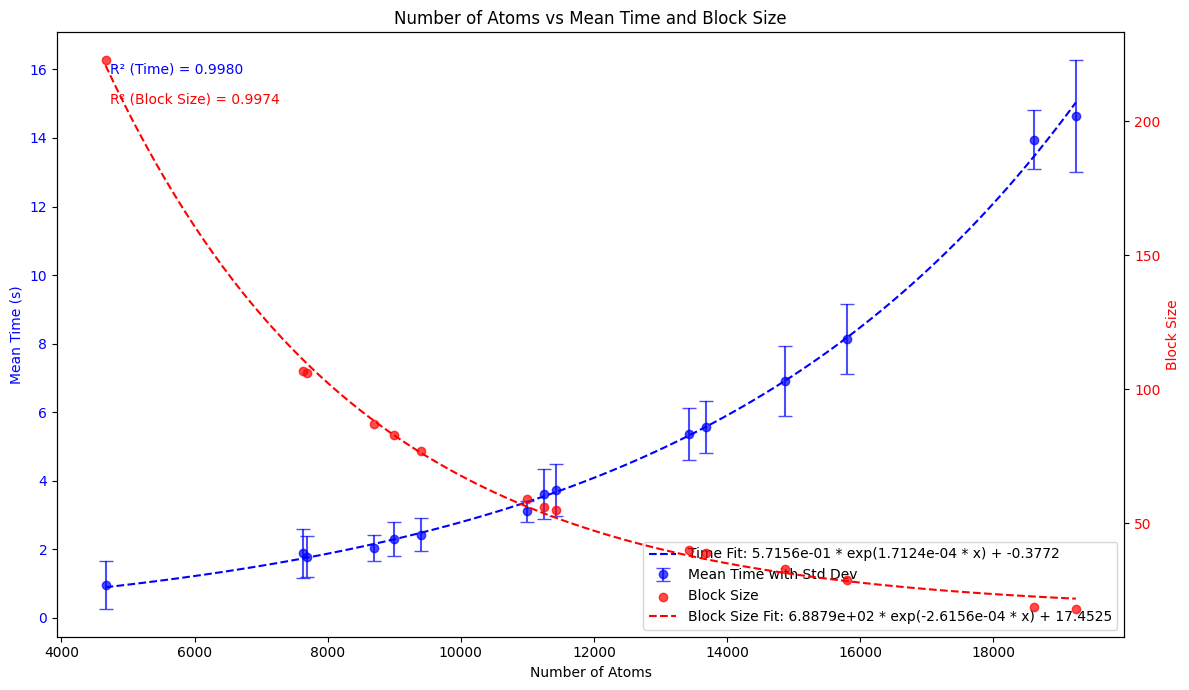

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


# Group by PDB file and take the first row for each
grouped_data = df.groupby('PDB_File').first().reset_index()

# Exponential fitting function for Mean Time (increasing)
def exp_func_time(x, a, b, c):
    return a * np.exp(b * x) + c

# Exponential decay function for Block Size
def exp_decay_func(x, a, b, c):
    return a * np.exp(-b * x) + c

# Prepare data for fitting
x = grouped_data['Number_of_Atoms']
y_time = grouped_data['Mean_Time']
y_blocksize = grouped_data['Block_Size']

# Perform curve fitting for Mean Time
popt_time, _ = curve_fit(exp_func_time, x, y_time, p0=[0.001, 0.0001, 1])

# Perform curve fitting for Block Size (using decay function)
popt_blocksize, _ = curve_fit(exp_decay_func, x, y_blocksize, p0=[100, 0.0001, 1])

# Generate points for the fitted curves
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit_time = exp_func_time(x_fit, *popt_time)
y_fit_blocksize = exp_decay_func(x_fit, *popt_blocksize)

# Create the plot with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 7))

# First y-axis - Mean Time
color1 = 'blue'
ax1.set_xlabel('Number of Atoms')
ax1.set_ylabel('Mean Time (s)', color=color1)
ax1.errorbar(grouped_data['Number_of_Atoms'], grouped_data['Mean_Time'], 
             yerr=grouped_data['Std_Time'], 
             fmt='o', 
             capsize=5, 
             color=color1, 
             alpha=0.7, 
             label='Mean Time with Std Dev')
ax1.plot(x_fit, y_fit_time, color=color1, linestyle='--', 
         label=f'Time Fit: {popt_time[0]:.4e} * exp({popt_time[1]:.4e} * x) + {popt_time[2]:.4f}')
ax1.tick_params(axis='y', labelcolor=color1)

# Calculate R-squared for Mean Time
residuals_time = y_time - exp_func_time(x, *popt_time)
ss_res_time = np.sum(residuals_time**2)
ss_tot_time = np.sum((y_time - np.mean(y_time))**2)
r_squared_time = 1 - (ss_res_time / ss_tot_time)

# Second y-axis - Block Size
ax2 = ax1.twinx()
color2 = 'red'
ax2.set_ylabel('Block Size', color=color2)
ax2.scatter(grouped_data['Number_of_Atoms'], grouped_data['Block_Size'], 
            color=color2, alpha=0.7, label='Block Size')
ax2.plot(x_fit, y_fit_blocksize, color=color2, linestyle='--', 
         label=f'Block Size Fit: {popt_blocksize[0]:.4e} * exp(-{popt_blocksize[1]:.4e} * x) + {popt_blocksize[2]:.4f}')
ax2.tick_params(axis='y', labelcolor=color2)

# Calculate R-squared for Block Size
residuals_blocksize = y_blocksize - exp_decay_func(x, *popt_blocksize)
ss_res_blocksize = np.sum(residuals_blocksize**2)
ss_tot_blocksize = np.sum((y_blocksize - np.mean(y_blocksize))**2)
r_squared_blocksize = 1 - (ss_res_blocksize / ss_tot_blocksize)

# Title and layout
plt.title('Number of Atoms vs Mean Time and Block Size')
fig.tight_layout()

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

# Add R-squared annotations
ax1.annotate(f'R² (Time) = {r_squared_time:.4f}', 
             xy=(0.05, 0.95), 
             xycoords='axes fraction', 
             fontsize=10, 
             color=color1,
             verticalalignment='top')
ax1.annotate(f'R² (Block Size) = {r_squared_blocksize:.4f}', 
             xy=(0.05, 0.90), 
             xycoords='axes fraction', 
             fontsize=10, 
             color=color2,
             verticalalignment='top')

# Save the plot
plt.savefig('atoms_vs_time_and_blocksize.png')

# Print fitting details
print("Mean Time Exponential Fitting Details:")
print(f"Equation: y = {popt_time[0]:.4e} * exp({popt_time[1]:.4e} * x) + {popt_time[2]:.4f}")
print(f"R-squared: {r_squared_time:.4f}")

print("\nBlock Size Exponential Decay Fitting Details:")
print(f"Equation: y = {popt_blocksize[0]:.4e} * exp(-{popt_blocksize[1]:.4e} * x) + {popt_blocksize[2]:.4f}")
print(f"R-squared: {r_squared_blocksize:.4f}")

# Print data with predictions
grouped_data['Predicted_Time'] = exp_func_time(grouped_data['Number_of_Atoms'], *popt_time)
grouped_data['Time_Residual'] = grouped_data['Mean_Time'] - grouped_data['Predicted_Time']
grouped_data['Predicted_BlockSize'] = exp_decay_func(grouped_data['Number_of_Atoms'], *popt_blocksize)
grouped_data['BlockSize_Residual'] = grouped_data['Block_Size'] - grouped_data['Predicted_BlockSize']

print("\nData with Predictions:")
print(grouped_data[['PDB_File', 'Number_of_Atoms', 'Mean_Time', 'Predicted_Time', 'Time_Residual', 
                    'Block_Size', 'Predicted_BlockSize', 'BlockSize_Residual']].to_string(index=False))